# Exercise 1: Introduction to Machine Learning and Life Sciences

## Install packages

We start by installing the required packages into the same environment we use as the kernel for this Jupyter notebook using `pip`. If you are unfamiliar with Jupyter notebooks, please refer to: https://jupyter.org/ for setting up and using a Jupyter server.

In [22]:
!pip3 install -U --quiet scikit-learn==1.3.2 pandas==2.0.3 torch==2.4.1 matplotlib requests

## Import libraries and download dataset

In [23]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from statistics import mean, stdev
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, KFold
from sklearn import metrics
from sklearn.exceptions import ConvergenceWarning

## Parse and Preprocess Data

Download the ELAV1 dataset (`ELAV1_PARCLIP.txt`) from https://github.com/BackofenLab/ML_LS_resources/blob/master/exercise_1_introduction/ELAVL1_PARCLIP.txt

We will featurize the sequences by creating k-mers with k=3, which will result in 4^3 = 64 predictor variables

In [25]:
# list all possible three-mers
three_mers = [  # AAA, AAC, AAG ...
    f"{a}{b}{c}"
    for a in ["A", "C", "U", "G"]
    for b in ["A", "C", "U", "G"]
    for c in ["A", "C", "U", "G"]
]

# get data, one list element per entry1
with open("../ELAVL1_PARCLIP.txt") as f:
    data_text = f.read().split("\n>")

data = []
# parse all data elements to get target variable and counts for k-mers
for datum_text in data_text:
    datum = {"target": datum_text.split("\n")[0].split("|")[-1]}
    seq = datum_text.split("\n")[-1]
    for three_mer in three_mers:
        datum[three_mer] = seq.count(three_mer)
    data.append(datum)

# convert to pandas dataframe
df = pd.DataFrame(data)
df

,target,AAA,AAC,AAU,AAG,ACA,ACC,ACU,ACG,AUA,...,GCU,GCG,GUA,GUC,GUU,GUG,GGA,GGC,GGU,GGG
0,1,3,0,3,1,2,3,0,0,1,...,0,0,0,1,2,0,2,0,1,1
1,0,3,1,4,1,2,1,1,0,4,...,1,0,1,0,1,3,3,0,2,0
2,0,2,3,1,0,3,2,0,0,1,...,1,0,1,1,2,0,1,1,0,0
3,0,1,2,1,4,1,2,0,0,1,...,1,0,1,0,0,1,3,1,0,0
4,1,2,0,5,0,1,0,1,0,2,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,0,1,0,1,3,2,0,1,...,3,1,1,1,0,0,0,2,2,2
9996,0,3,4,4,1,3,0,1,0,2,...,1,0,0,0,1,2,0,2,2,0
9997,0,2,0,1,2,3,1,2,0,3,...,0,0,3,0,0,1,0,0,1,0
9998,0,1,1,0,1,0,3,1,0,0,...,3,0,0,1,1,2,1,3,2,2


## Construct Classifier Models

We will now train a simple machine learning classifier on the data. We can select and implement a simple classifier easily from scikit-learn. We will first format our dataset from before by splitting the dataset into a train and test split using `train_test_split()` with the stratified option to ensure class balance is taken into account when splitting the dataset. 

For more information, refer to https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [26]:
# Split data into train and test sets

X = df.iloc[:, 1:]
y = df["target"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=100
)

Then select a classifier from scikit-learn. One possible choice is the Random Forest Classifier implementation at https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. Construct this classifier and then call the `fit()` function on it and pass the training samples, `X_train` and the targets, `y_train`

In [27]:
# Fit a classifier model
rfc = RandomForestClassifier(n_estimators=200, random_state=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=100)

Evaluate the trained classifer on our test data, obtained from the stratified train-test split before. To evaluate our model on the test data, we must first obtain its predictions using `predict()` and passing the test samples, `X_test`. We then compute the following evaluation metrics using these predictions and the test labels, `y_test`: AUCROC, accuracy, precision, recall, and f1-score.

In [28]:
rfc_predictions = rfc.predict(X_test)
print("Metrics for random forest:")
print(f"AUCROC: {metrics.roc_auc_score(y_test, rfc_predictions)}")
print(f"Accuracy: {metrics.accuracy_score(y_test, rfc_predictions)}")
print(f"Precision: {metrics.precision_score(y_test, rfc_predictions)}")
print(f"Recall: {metrics.recall_score(y_test, rfc_predictions)}")
print(f"F1: {metrics.f1_score(y_test, rfc_predictions)}")
print("\n\n")


Metrics for random forest:
AUCROC: 0.793
Accuracy: 0.793
Precision: 0.7704615384615384
Recall: 0.8346666666666667
F1: 0.8012799999999999





Now implement, train, and evaluate another classfier from scratch to compare their performance. This time, train the model using 5-fold cross-validation and then evaluate it on the average of the 5 runs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [29]:
# silence the warning 
warnings.filterwarnings("ignore", category=ConvergenceWarning)


log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, solver="lbfgs", n_jobs=-1)  
)

log_reg.fit(X_train, y_train)

y_pred   = log_reg.predict(X_test)
y_scores = log_reg.predict_proba(X_test)[:, 1]        

holdout_scores = {
    "AUROC"    : metrics.roc_auc_score(y_test, y_scores),
    "Accuracy" : metrics.accuracy_score(y_test, y_pred),
    "Precision": metrics.precision_score(y_test, y_pred),
    "Recall"   : metrics.recall_score(y_test, y_pred),
    "F1"       : metrics.f1_score(y_test, y_pred)
}

cv = KFold(n_splits=5, shuffle=True, random_state=1)

cv_scores = cross_validate(
    log_reg,
    X, y,
    scoring=["roc_auc", "accuracy", "precision", "recall", "f1"],
    cv=cv,
    n_jobs=-1
)

summary = {
    "AUROC"    : (mean(cv_scores["test_roc_auc"]),    stdev(cv_scores["test_roc_auc"])),
    "Accuracy" : (mean(cv_scores["test_accuracy"]),   stdev(cv_scores["test_accuracy"])),
    "Precision": (mean(cv_scores["test_precision"]),  stdev(cv_scores["test_precision"])),
    "Recall"   : (mean(cv_scores["test_recall"]),     stdev(cv_scores["test_recall"])),
    "F1"       : (mean(cv_scores["test_f1"]),         stdev(cv_scores["test_f1"]))
}

print("Cross-validated metrics")
print(pd.DataFrame(summary, index=["mean", "stdev"]).T.round(3).to_string())

Cross-validated metrics
            mean  stdev
AUROC      0.865  0.007
Accuracy   0.791  0.008
Precision  0.780  0.012
Recall     0.813  0.011
F1         0.796  0.005


## Multi-layer perceptron

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F            
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

In [75]:
# Hyper-parameters
input_size   = X_train.shape[1]
hidden_size  = 64
output_size  = 2
learning_rate = 1e-4
batch_size    = 128
epochs        = 5

In [76]:
# Define the model 
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = MLP(input_size, hidden_size, output_size)

In [77]:
# Convert to tensors and create DataLoaders
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test.values,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values,  dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor),
                          batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_tensor,  y_test_tensor),
                          batch_size=batch_size, shuffle=False)

In [78]:
# Deifne loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [79]:
# Define evaluation helper method
def evaluate(model, loader):
    model.eval()
    total_loss, y_true, y_pred, y_prob = 0, [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            total_loss += criterion(logits, yb).item()
            probs  = F.softmax(logits, dim=1)[:, 1].numpy()
            preds  = np.round(probs)
            y_true.extend(yb.numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)
    y_true, y_pred, y_prob = map(np.array, (y_true, y_pred, y_prob))
    return (
        total_loss / len(loader),
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, zero_division=0),
        recall_score(y_true, y_pred, zero_division=0),
        f1_score(y_true, y_pred, zero_division=0),
        roc_auc_score(y_true, y_prob),
    )

In [80]:
# Training loop 
train_losses, test_losses = [], []  

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    avg_test_loss, acc, prec, rec, f1, auroc = evaluate(model, test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch}/{epochs} | "
          f"train_loss: {avg_train_loss:.4f}  "
          f"test_loss: {avg_test_loss:.4f}  "
          f"acc: {acc:.3f}  prec: {prec:.3f}  rec: {rec:.3f}  f1: {f1:.3f}  auroc: {auroc:.3f}")

print("Training complete!")

Epoch 1/5 | train_loss: 0.6245  test_loss: 0.5782  acc: 0.761  prec: 0.745  rec: 0.795  f1: 0.769  auroc: 0.834
Epoch 2/5 | train_loss: 0.5588  test_loss: 0.5232  acc: 0.772  prec: 0.744  rec: 0.829  f1: 0.784  auroc: 0.852
Epoch 3/5 | train_loss: 0.5173  test_loss: 0.4898  acc: 0.778  prec: 0.759  rec: 0.816  f1: 0.786  auroc: 0.857
Epoch 4/5 | train_loss: 0.4935  test_loss: 0.4721  acc: 0.781  prec: 0.754  rec: 0.835  f1: 0.793  auroc: 0.861
Epoch 5/5 | train_loss: 0.4812  test_loss: 0.4616  acc: 0.785  prec: 0.766  rec: 0.823  f1: 0.793  auroc: 0.864
Training complete!


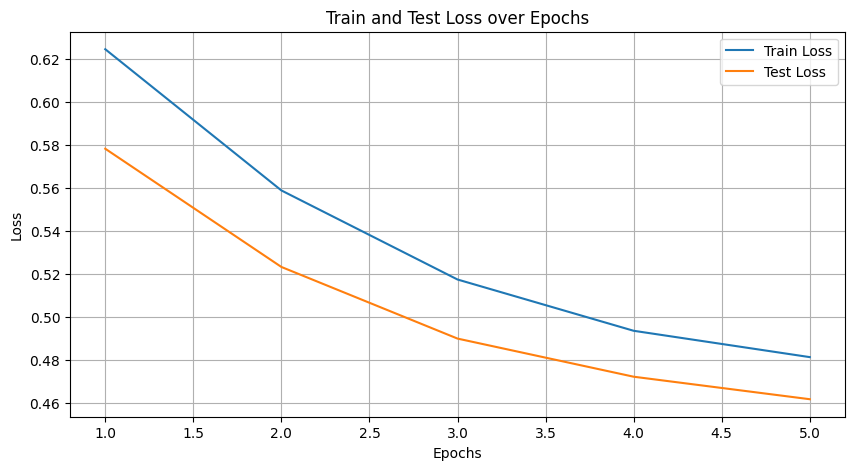

In [81]:
# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.show()

# Improve the performance

After comparing the performances of the previous three classifers, explore other techniques, architectures, and strategies to further improve the final performance.

The following is a minimal self-contained training and evaluation run of a more advanced deep learning ensemble for the previous task. The performance by default is worse than the MLP. Modify the existing code and feel free to add or remove any techniques and components to run experiments and observe how they affect the final performance. Try to beat the AUROC of the MLP.

In [ ]:

import json, random, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, \
                            accuracy_score, f1_score, precision_score, recall_score

# Check that sequences and labels exist 
try:
    seqs, labels
except NameError:
    def _load(path="ELAVL1_PARCLIP.txt"):
        s, y = [], []
        with open(path) as fh:
            for block in fh.read().strip().split("\n>"):
                block = block.lstrip(">")
                head, *seq = block.split("\n")
                s.append("".join(seq).strip().upper())
                y.append(int(head.split("|")[-1]))
        return s, np.asarray(y)
    seqs, labels = _load()

# One-hot encoding and light augmentation
_nt2i = {"A":0,"C":1,"G":2,"U":3}
def one_hot(ss, L=40):
    x = np.zeros((len(ss),4,L),np.float32)
    for i,s in enumerate(ss):
        for j,ch in enumerate(s[:L]):
            if ch in _nt2i: x[i,_nt2i[ch],j]=1
    return x
def augment(ss, yy, p=0.3):
    nts = np.array(list(_nt2i.keys())); rng=np.random.default_rng()
    augS, augY = [], []
    for s,l in zip(ss,yy):
        arr=np.array(list(s))
        m=rng.random(len(arr))<p
        if m.any(): arr[m]=rng.choice(nts,m.sum())
        augS.append("".join(arr)); augY.append(l)
    return ss+augS, np.concatenate([yy, np.asarray(augY)])

class DS(Dataset):
    def __init__(self,X,y):
        self.X=torch.from_numpy(X); self.y=torch.tensor(y,dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(s,i): return s.X[i],s.y[i]

# Tiny CNN model
class TinyCNN(nn.Module):
    def __init__(self,L):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv1d(4,64,Kernel_size:=7,padding=3), nn.ReLU(),
            nn.Conv1d(64,128,5,padding=2),           nn.ReLU(),
            nn.Conv1d(128,128,3,padding=1),          nn.ReLU(),
            nn.AdaptiveMaxPool1d(1))
        self.fc=nn.Linear(128,1)
    def forward(self,x): return self.fc(self.net(x).squeeze(-1)).squeeze(-1)

# Training and evaluation
def metrics(y,p):
    b=(p>=0.5).astype(int)
    return dict(
        auroc=roc_auc_score(y,p),
        aupr=average_precision_score(y,p),
        accuracy=accuracy_score(y,b),
        f1=f1_score(y,b),
        precision=precision_score(y,b),
        recall=recall_score(y,b))

def run(seed):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    S,L = augment(seqs,labels)
    X = one_hot(S); y=L
    X_tr,X_tmp,y_tr,y_tmp = train_test_split(X,y,test_size=0.3,
                                            stratify=y,random_state=seed)
    X_val,X_te,y_val,y_te = train_test_split(X_tmp,y_tmp,test_size=0.5,
                                            stratify=y_tmp,random_state=seed)
    tr_dl = DataLoader(DS(X_tr,y_tr),batch_size=256,shuffle=True)
    val_dl= DataLoader(DS(X_val,y_val),batch_size=512)
    te_dl = DataLoader(DS(X_te,y_te), batch_size=512)

    dev=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net=TinyCNN(X.shape[-1]).to(dev)
    opt=torch.optim.Adam(net.parameters(),lr=1e-4,weight_decay=1e-4)
    crit=nn.BCEWithLogitsLoss()

    best,wait,STOP=0,0,5
    for ep in range(30):
        net.train()
        for xb,yb in tr_dl:
            xb,yb=xb.to(dev),yb.to(dev)
            opt.zero_grad()
            loss=crit(net(xb),yb); loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(),5)
            opt.step()
        # val
        net.eval(); pr=[]
        with torch.no_grad():
            for xb,_ in val_dl:
                pr.append(torch.sigmoid(net(xb.to(dev))).cpu().numpy())
        pr=np.concatenate(pr); auc=roc_auc_score(y_val,pr)
        if auc>best: best,wait,bstate=auc,0,net.state_dict()
        else:
            wait+=1
            if wait>=STOP: break

    net.load_state_dict(bstate); net.eval(); pr=[]
    with torch.no_grad():
        for xb,_ in te_dl:
            pr.append(torch.sigmoid(net(xb.to(dev))).cpu().numpy())
    return np.concatenate(pr), y_te

# Two-seed ensemble
preds=[]; y=None
for s in (0,22):
    p,y=run(s); preds.append(p)
out=np.mean(preds,0)
print(json.dumps(metrics(y,out),indent=2))


{
  "auroc": 0.7331022222222222,
  "aupr": 0.7230374417806534,
  "accuracy": 0.658,
  "f1": 0.6622778143515471,
  "precision": 0.6540962288686606,
  "recall": 0.6706666666666666
}
